### Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib.dates as mdates
from scipy import stats

warnings.filterwarnings("ignore")

### Reading and Exploring Data

In [ ]:
# Read train and test data
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Maze/Time Series Forecasting/weather_ts_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Maze/Time Series Forecasting/weather_ts_test.csv')

In [ ]:
# View first few rows of our training data
train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
# View last few rows of our training data
train_df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [ ]:
# View first few rows of our test data
test_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [ ]:
# View last few rows of our test data
test_df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


In [ ]:
# Check data types
train_df.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

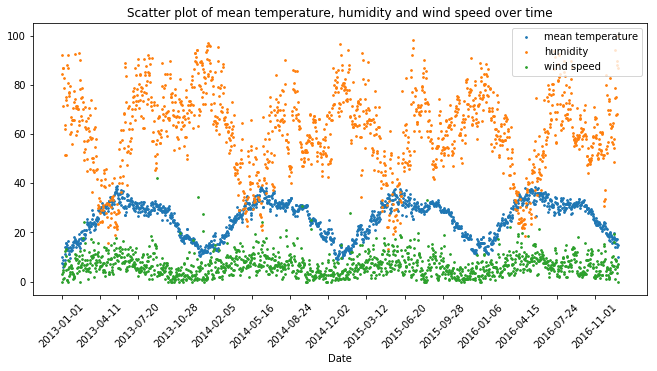

In [ ]:
# Plot the data points for mean temperature, humidity and wind speed over time as they are on similar scales

plt.figure(figsize=(11, 5))

plt.scatter(train_df["date"], train_df["meantemp"], s=3, label='mean temperature')
plt.scatter(train_df["date"], train_df["humidity"], s=3, label='humidity')
plt.scatter(train_df["date"], train_df["wind_speed"], s=3, label='wind speed')

# Set the frequency of x-axis ticks (every 100 days)
plt.xticks(train_df["date"][::100], rotation=45)

# Add labels and a legend
plt.xlabel('Date')
plt.title('Scatter plot of mean temperature, humidity and wind speed over time')
plt.legend()

Mean Pressure was not ploted because its on a different scale.
- Looking at the plot, it is noticed that when Humidity increases, Mean Temperature decreases, forming an inverse relationship between the two.
- Looking at Wind Speed, Mean Temperature, it can be seen that when Wind Sped increases, Mean Temperature increases.

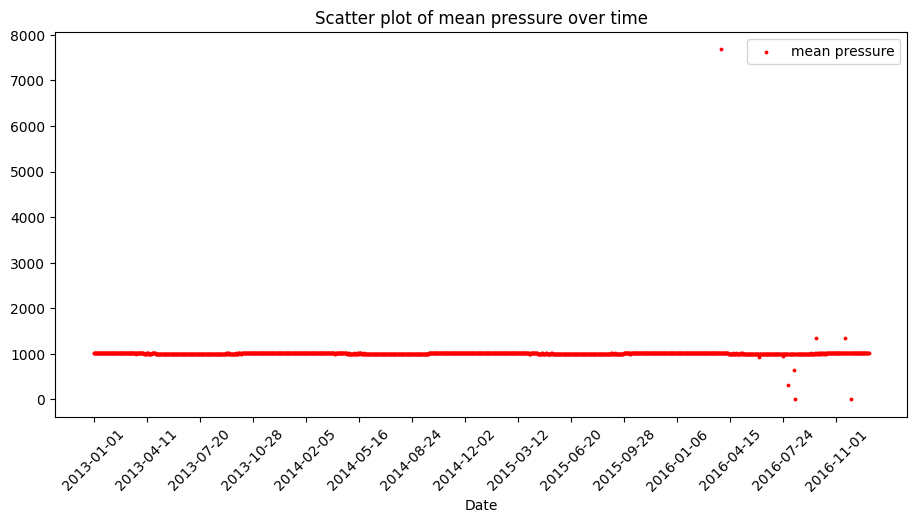

In [ ]:
# Plot the data points for mean pressure over time

plt.figure(figsize=(11, 5))

plt.scatter(train_df["date"], train_df["meanpressure"], s=3, label='mean pressure', color = "red")

# Set the frequency of x-axis ticks (every 100 days)
plt.xticks(train_df["date"][::100], rotation=45)

# Add labels and a legend
plt.xlabel('Date')
plt.title('Scatter plot of mean pressure over time')
plt.legend()

The Mean Pressure contains Outliers which can negatively impact our gradient boosting algorithm, so we can remove them.

### Data Preprocessing

In [ ]:
# Convert date to datetime
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] =  pd.to_datetime(test_df["date"])

# Set index for both dataframes as date
train_df.index = train_df["date"]
test_df.index = test_df["date"]

# Drop date column since its now the indezx
train_df.drop(["date"],1,inplace= True)
test_df.drop(["date"],1,inplace= True)

# Remove Outliers, all point lie within 3 SD of the mean
train_df = train_df[(np.abs(stats.zscore(train_df)) < 3).all(axis=1)]
test_df = test_df[(np.abs(stats.zscore(test_df)) < 3).all(axis=1)]

##### Feature Engineering

In [ ]:
# Produce date time features
# To check if our day of the can influence our mean temperature
train_df['day_of_week'] = train_df.index.dayofweek
# To check if our month of the can influence our mean temperature
train_df['month'] = train_df.index.month

# To check if our day of the can influence our mean temperature
test_df['day_of_week'] = test_df.index.dayofweek
# To check if our month of the can influence our mean temperature
test_df['month'] = test_df.index.month

# Produce lag features for the past 3 days
# this enables us to model Serail dependence
for i in range(1, 4):
    train_df[f'meantemp_lag_{i}'] = train_df['meantemp'].shift(i)
    test_df[f'meantemp_lag_{i}'] = test_df['meantemp'].shift(i)

##### Further Preprocessing

In [ ]:
# Drop rows with missing values produced by lag operations
train_df = train_df.dropna()
test_df = test_df.dropna()

# Produce lightgbm datasets from dataframes ready for modelling
train_data = lgb.Dataset(train_df.drop('meantemp', axis=1), label=train_df['meantemp'])
test_data = lgb.Dataset(test_df.drop('meantemp', axis=1), label=test_df['meantemp'])

### Modelling

In [ ]:
# Define parameters for LightGBM modelling
# Cross Validation and Hyperparameter Optimization can be used

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_iterations': 1000
}

In [ ]:
model = lgb.train(params, train_data)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1545
[LightGBM] [Info] Number of data points in the train set: 1441, number of used features: 8
[LightGBM] [Info] Start training from score 25.542160


### Model Evaluation

In [ ]:
test_df.head()

,meantemp,humidity,wind_speed,meanpressure,day_of_week,month,meantemp_lag_1,meantemp_lag_2,meantemp_lag_3
date,,,,,,,,,
2017-01-05,18.388889,74.944444,3.300000,1014.333333,3,1,18.700000,17.111111,18.500000
2017-01-06,19.318182,79.318182,8.681818,1011.772727,4,1,18.388889,18.700000,17.111111
2017-01-07,14.708333,95.833333,10.041667,1011.375000,5,1,19.318182,18.388889,18.700000
2017-01-08,15.684211,83.526316,1.950000,1015.550000,6,1,14.708333,19.318182,18.388889
2017-01-09,14.571429,80.809524,6.542857,1015.952381,0,1,15.684211,14.708333,19.318182


R Squared Score 0.9217123851211761 



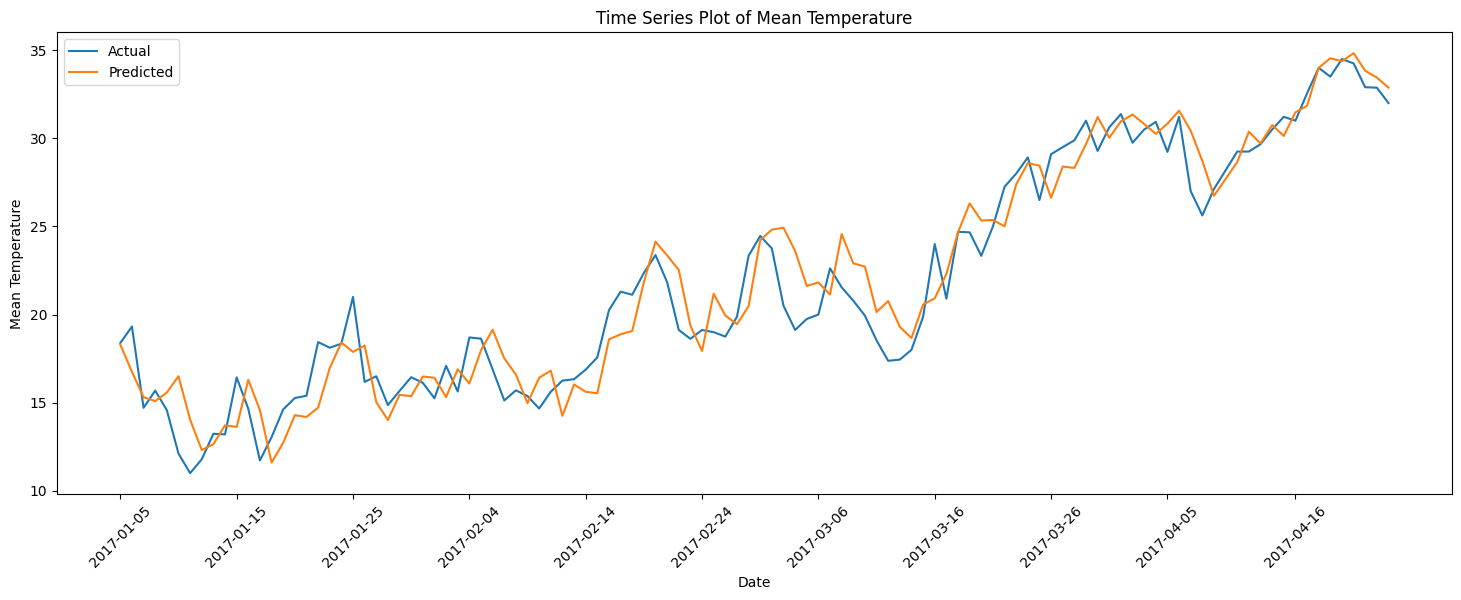

In [ ]:
from sklearn.metrics import r2_score

# Generate a set of predictions
predictions = model.predict(test_df.drop('meantemp', axis=1))

# Check r2 score
mse = r2_score(test_df['meantemp'], predictions)
print(f'R Squared Score {mse}','\n')

#=== Visualize Actual vs. Predicted values ======

plt.figure(figsize=(18, 6))
plt.plot(test_df.index, test_df['meantemp'], label='Actual')
plt.plot(test_df.index, predictions, label='Predicted')

# Add axis labels
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Time Series Plot of Mean Temperature')

# Set the frequency of x-axis ticks (every 10 days)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(test_df.index[::10], rotation=45)

# Add legend
plt.legend()